In [21]:
import matplotlib
matplotlib.use('Agg')

import os
import cv2
import scipy
import numpy as np
from skimage.feature import hog
from sklearn import preprocessing
from sklearn.externals import joblib
from keras.utils.np_utils import to_categorical

In [22]:
from matplotlib import pyplot as plt

%matplotlib inline

In [23]:
def plot_things(things, labels):
    count = len(things)
    plt.figure(figsize=(20, 20))
    
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    for i, thing in enumerate(things):
        cols = 10
        rows = int(count / cols) + 1
        ax = plt.subplot(rows, cols, 1 + i)
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(labels[i])

        plt.imshow(thing)
    plt.show()

In [26]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
data = mnist.data
target = mnist.target

# Singles

In [27]:
single_labels = np.zeros(data.shape[0])
single_labels = to_categorical(single_labels, num_classes=2)


# DBLs

In [28]:
import random
from skimage.filters import threshold_otsu

def random_combination(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(xrange(n), r))
    return tuple(pool[i] for i in indices)

def remove_border(img):
    where = np.where(img > 0)
    y1 = np.min(where[0])
    y2 = np.max(where[0])
    x1 = np.min(where[1])
    x2 = np.max(where[1])
    crop = img[y1:y2 , x1:x2]
    return crop

n_samples = 1000000
combs = []
combs_labels = []
data_w_labels = zip(data, target)
random.shuffle(data_w_labels)

for i in range(n_samples):
    comb = random_combination(data_w_labels, 2)
    
    first_digit = comb[0][0].reshape((28, 28))
    second_digit = comb[1][0].reshape((28, 28))

#     thresh = threshold_otsu(first_digit)
#     first_digit = (first_digit > thresh).astype(np.uint8)
    
#     thresh = threshold_otsu(second_digit)
#     second_digit = (second_digit > thresh).astype(np.uint8)
    
    first_mod = remove_border(first_digit)
    second_mod = remove_border(second_digit)
    
    # Make sure height diff is divisible by 2
    if not (first_mod.shape[0] % 2 == 0):
        first_mod = np.vstack([first_mod, np.zeros((1, first_mod.shape[1]))])
    if not (second_mod.shape[0] % 2 == 0):
        second_mod = np.vstack([second_mod, np.zeros((1, second_mod.shape[1]))])
    
    height_diff = first_mod.shape[0] - second_mod.shape[0]
    
    if height_diff < 0:
        padding = int(-height_diff / 2.0)
        thepad = np.zeros((padding, first_mod.shape[1]))
        first_mod = np.vstack([first_mod, thepad])
        first_mod = np.vstack([thepad, first_mod])
    elif height_diff > 0:
        padding = int(height_diff / 2.0)
        thepad = np.zeros((padding, second_mod.shape[1]))
        second_mod = np.vstack([second_mod, thepad])
        second_mod = np.vstack([thepad, second_mod])
    
    # Align width
    overlap = 1
    
    height = first_mod.shape[0]
    width_1 = first_mod.shape[1]
    width_2 = second_mod.shape[1]
    
    padding = np.zeros((height, width_2 - overlap))
    first_mod = np.hstack([first_mod, padding])
    padding = np.zeros((height, width_1 - overlap))
    second_mod = np.hstack([padding, second_mod])
    
    overlapped = first_mod.astype(np.uint64) + second_mod.astype(np.uint64)
    overlapped = np.clip(overlapped, 0, 255).astype(np.uint8)
    padded = np.pad(overlapped, (5, 5), 'constant', constant_values=(0, 0))  
    
#     binary = (padded > 0).astype(np.uint8)
    combs.append(padded)
    
    label = int(  str(int(comb[0][1])) + str(int(comb[1][1]))  )
    combs_labels.append( 1 )
    
# combs = np.array(combs)
combs_labels = np.array(combs_labels)

In [29]:
combs_reshaped = [cv2.resize(x, (28, 28)) for x in combs]

In [ ]:
i = 50
plot_things(combs_reshaped[i:i + 50], combs_labels[i:i + 50])

# Train Classifier

In [106]:
# Extract the features and labels
combs_np = np.array(combs_reshaped)
dbl_features = np.expand_dims(combs_np.reshape(1000000, 28, 28), axis=3)
dbl_labels = to_categorical(combs_labels)

reshaped_data = data.reshape((70000, 28, 28))
expanded_data = np.expand_dims(reshaped_data, axis=3)
dbl_single_feats = np.concatenate([expanded_data, dbl_features], axis=0)
dbl_single_labels = np.concatenate([single_labels, dbl_labels], axis=0)

dbl_single_feats_balanced = np.concatenate([expanded_data, dbl_features[0:70000]], axis=0)
db_single_labels_balanced = np.concatenate([single_labels, dbl_labels[0:70000]], axis=0)

In [267]:
import pickle
with open("./dbl_single_feats.pkl", 'wb') as f:
    pickle.dump(dbl_single_feats, f)
with open("./dbl_single_labels.pkl", 'wb') as f:
    pickle.dump(dbl_single_labels, f)
    
with open("./dbl_single_feats_balanced.pkl", 'wb') as f:
    pickle.dump(dbl_single_feats_balanced, f)
with open("./dbl_single_labels_balanced.pkl", 'wb') as f:
    pickle.dump(db_single_labels_balanced, f)

In [268]:
dbl_single_feats.shape, dbl_single_labels.shape

((1070000, 28, 28, 1), (1070000, 2))

In [269]:
dbl_single_feats_balanced.shape, db_single_labels_balanced.shape

((140000, 28, 28, 1), (140000, 2))

In [270]:
import keras
from keras import applications
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


def get_model():
    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape=(28, 28, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model


batch_size = 512
num_classes = 10
epochs = 7

model = get_model()

In [ ]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

history_bn = model.fit(
    dbl_single_feats_balanced,
    db_single_labels_balanced,
    validation_split=0.05,
    batch_size=batch_size,
    callbacks=[earlyStopping], 
    epochs=epochs
)

# Save the classifier
model.save(filepath='./models/double_digits_differentiator_cnn')

# Differentiate based on HOG features

In [149]:
def calc_hog_feats(features):
    list_hog_fd = []
    for feature in features:
        fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
        list_hog_fd.append(fd)
    hog_features = np.array(list_hog_fd, 'float64')
    return hog_features

dbl_single_feats_balanced_hog = calc_hog_feats(dbl_single_feats_balanced)
dbl_single_labels_balanced = dbl_single_labels_balanced

# Normalize the features
pp = preprocessing.StandardScaler().fit(dbl_single_feats_balanced_hog)
hog_features = pp.transform(dbl_single_feats_balanced_hog)
with open("./models/dbl_single_feats_balanced_pp.pkl", 'wb') as f:
    pickle.dump(pp, f)

In [153]:
dbl_single_feats_balanced_hog.shape, dbl_single_labels_balanced.shape

((140000, 36), (140000, 2))

In [262]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split

argmaxed = np.argmax(dbl_single_labels_balanced, axis=1)
x_train, x_test, y_train, y_test = train_test_split(dbl_single_feats_balanced_hog, argmaxed)

# clf = SGDClassifier(loss="hinge", penalty="l2", class_weight='balanced')
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

print clf.score(x_test, y_test)

# Save the classifier
joblib.dump(clf, "./models/dbl_digits_differentiator_balanced_hog.pkl", compress=3)

0.949885714286


['./models/dbl_digits_differentiator_balanced_hog.pkl']

# Test the differentiator

In [263]:
# clf, pp = joblib.load('./models/digits_cls.pkl')
# model = keras.models.load_model('./models/double_digits_cnn_nonbinary')
# model_single = keras.models.load_model('./models/digits_cnn_new')
model_differentiator = keras.models.load_model('./models/double_digits_differentiator_cnn')
model_differentiator = joblib.load('./models/dbl_digits_differentiator_balanced_hog.pkl')
dbl_single_feats_pp = joblib.load('./dbl_single_feats_balanced_pp.pkl')

In [99]:
imgs = [1,6,12,21,41,42,51,52,56,83,84,89,90,96,97,106,123,131,136,152,153,156,157] #7, 22
filenames = ['../data/gels_nov_2016/Im{} - p. {}.png'.format(i, i) for i in imgs]
images = [scipy.misc.imread(f) for f in filenames]

april_imgs = [f for f in os.listdir('../data/april_2016_gels_renamed') if not 'tore' in f]
april_filenames = ['../data/april_2016_gels_renamed/{}'.format(f) for f in april_imgs]
april_images = [scipy.misc.imread(f) for f in april_filenames]

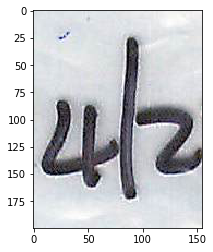

In [216]:
im = april_images[33][2200:2400,500:655]
plt.imshow(im)

In [264]:
def check_dbl(roi):
    hog_feats = calc_hog_feats_single(roi)
    is_dbl = model_differentiator.predict(hog_feats)
#     is_dbl = model_differentiator.predict_classes(np.array([np.expand_dims(roi, 2)]), batch_size=1, verbose=0)
    return is_dbl

def calc_hog_feats_single(roi):
    fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    # Normalize the features
    hog_features = dbl_single_feats_pp.transform([fd])
    return hog_features

im_b = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_r = cv2.resize(im_b, (28 ,28), interpolation=cv2.INTER_NEAREST)
check_dbl(im_r)

array([0])

In [265]:
import random

random_dbls = random.sample(dbl_single_feats_balanced, 10000)
squeezed = [np.squeeze(x) for x in random_dbls]
results = [check_dbl(x) for x in squeezed]
ones = [x for i, x in enumerate(squeezed) if results[i][0] == 1]
zeros = [x for i, x in enumerate(squeezed) if results[i][0] == 0]

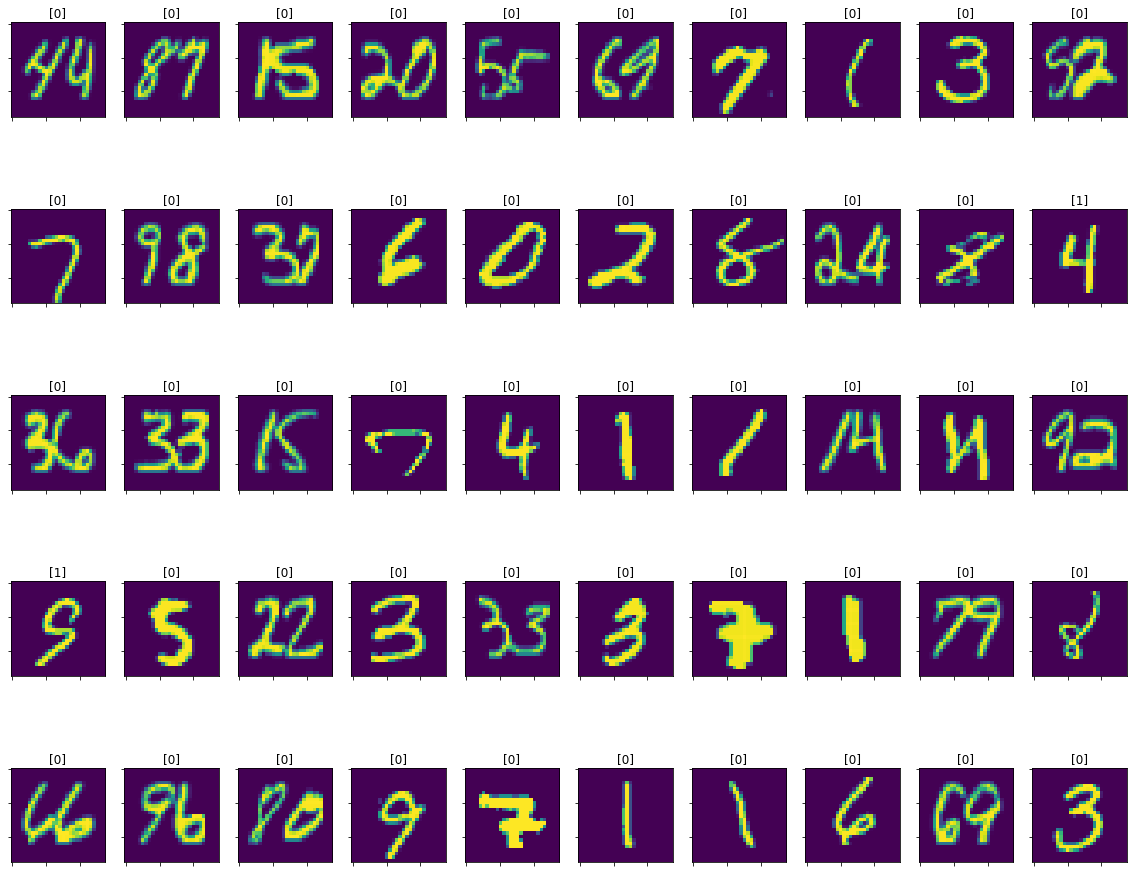

In [266]:
plot_things(zeros[0:50], results[0:100])

In [257]:
len(ones)

151